# Predicción de diabetes con Árboles de Decisión (Pima Indians Diabetes Dataset)

## 0. Importar librerias

In [112]:
# Data processing
# ==================================================================================
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pickle
import json
import numpy as np

# Charts
# ==================================================================================
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Preprocessing and modeling
# ==================================================================================
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import f_classif, SelectKBest

# Warnings Configuration
# ==================================================================================

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
from sklearn import tree

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV





import warnings

def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn # ignore annoying warning (from sklearn and seaborn)

pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points
'''NOTE: This affects only the display and not the underlying data, which remains unchanged.'''

'NOTE: This affects only the display and not the underlying data, which remains unchanged.'

# 1. Planteamiento del problema y recopilación de datos

## 1.1 Planteamiento de problema

En este proyecto utilizamos el dataset de Pima Indians Diabetes del 
National Institute of Diabetes and Digestive and Kidney Diseases.

**Objetivo:** predecir si un paciente tiene diabetes (`Outcome` = 1) a partir
de variables clínicas como glucosa, presión arterial, insulina, BMI, edad, etc.

## 1.2 Recopilación de datos

In [113]:
pd.options.display.max_columns=None
df = pd.read_csv("https://raw.githubusercontent.com/4GeeksAcademy/decision-tree-project-tutorial/main/diabetes.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.600,0.627,50,1
1,1,85,66,29,0,26.600,0.351,31,0
2,8,183,64,0,0,23.300,0.672,32,1
3,1,89,66,23,94,28.100,0.167,21,0
4,0,137,40,35,168,43.100,2.288,33,1


## 1.3 Exploración y limpieza de datos

Información de las variables:

- `Pregnancies`: Número de embarazos de la paciente (numérico).
- `Glucose`: Concentración plasmática de glucosa tras 2 horas de una prueba de tolerancia a la glucosa oral (numérico).
- `BloodPressure`: Presión arterial diastólica (medida en mmHg) (numérico).
- `SkinThickness`: Grosor del pliegue cutáneo tricipital (medido en mm) (numérico).
- `Insulin`: Insulina sérica a las 2 horas (medida en mu U/ml) (numérico).
- `BMI`: Índice de masa corporal (numérico).
- `DiabetesPedigreeFunction`: Función de pedigrí de diabetes (numérico).
- `Age`: Edad de la paciente (numérico).
- `Outcome`: Variable de clase (0 o 1), donde 0 significa diabetes negativa y 1 significa diabetes positiva (numérico).

In [114]:
print(f"Hay {df.shape[0]} filas y {df.shape[1]} columnas")

Hay 768 filas y 9 columnas


In [115]:
# Obtener información sobre tipos de datos y valores no nulos

df.info()

<class 'pandas.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [116]:
print(f"Valores unicos por columna: \n{df.nunique()}")

Valores unicos por columna: 
Pregnancies                  17
Glucose                     136
BloodPressure                47
SkinThickness                51
Insulin                     186
BMI                         248
DiabetesPedigreeFunction    517
Age                          52
Outcome                       2
dtype: int64


## Conclusiones:

### No existen valores nulos ni duplicados en el marco de datos, y contamos con características categóricas y numéricas.

## 1.4 Eliminación de información irrelevante y tratamiento de valores nulos

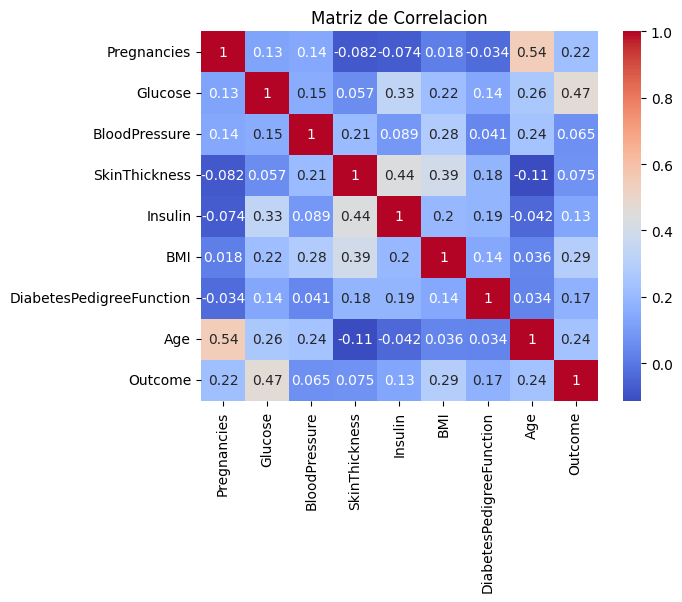

In [117]:
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Matriz de Correlacion")
plt.show()

In [118]:
print(f"Valores nulos por columna: \n{df.isnull().sum()}")

Valores nulos por columna: 
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


In [119]:
df_eda = df.copy()

num_duplicates = df_eda.duplicated().sum()
print(f"Número de filas duplicadas: {num_duplicates}")

if num_duplicates > 0:
    df_eda = df_eda.drop_duplicates().reset_index(drop=True)
    print(f"Se han eliminado {num_duplicates} filas duplicadas.")
    print(f"Ahora hay {df_eda.shape[0]} filas.")
else:
    print("No se han encontrado filas duplicadas.")

Número de filas duplicadas: 0
No se han encontrado filas duplicadas.


#### Para este conjunto de datos, conservaremos todas las características, ya que creemos que cada una desempeña un papel importante en la predicción del objetivo.

# 2. Anaalisis de variables Univariante

### Una variable univariante es un término estadístico que se emplea para referenciar un conjunto de observaciones de un atributo. Esto es, el análisis columna a columna del DataFrame. Para ello, debemos distinguir si una variable es categórica o numérica, ya que el cuerpo del análisis y las conclusiones que se pueden obtener serán distintas.

## 2.1 Análisis univariante de variables numéricas:

### Una variable numérica es un tipo de variable que puede tomar valores numéricos (enteros, fracciones, decimales, negativos, etc.) en un rango infinito. Una variable categórica numérica puede ser también una variable numérica (por ejemplo, para los sucesivos análisis, podemos tomar la clase Survived como numérica también para estudiar relaciones). Normalmente se representan utilizando un histograma y diagramas de caja, expuestos juntos.

In [120]:
numerical_var_int = []
numerical_var_float = []

for column in df_eda: 
    if (df_eda[column].dtype == 'int64') :
        numerical_var_int.append(column)
    elif (df_eda[column].dtype == 'float64'):
        numerical_var_float.append(column)

print(f"Variables numericas (int):\n\n{numerical_var_int}\n\nTotal = {len(numerical_var_int)}")
print(f"Variables numericas (float64):\n\n{numerical_var_float}\n\nTotal = {len(numerical_var_float)}")


Variables numericas (int):

['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'Age', 'Outcome']

Total = 7
Variables numericas (float64):

['BMI', 'DiabetesPedigreeFunction']

Total = 2


In [121]:
num_cols = df_eda.select_dtypes(include=["int64", "float64"]).columns.tolist()
print(f"Variables numéricas: {num_cols}")

num_vars = len(num_cols)

Variables numéricas: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']


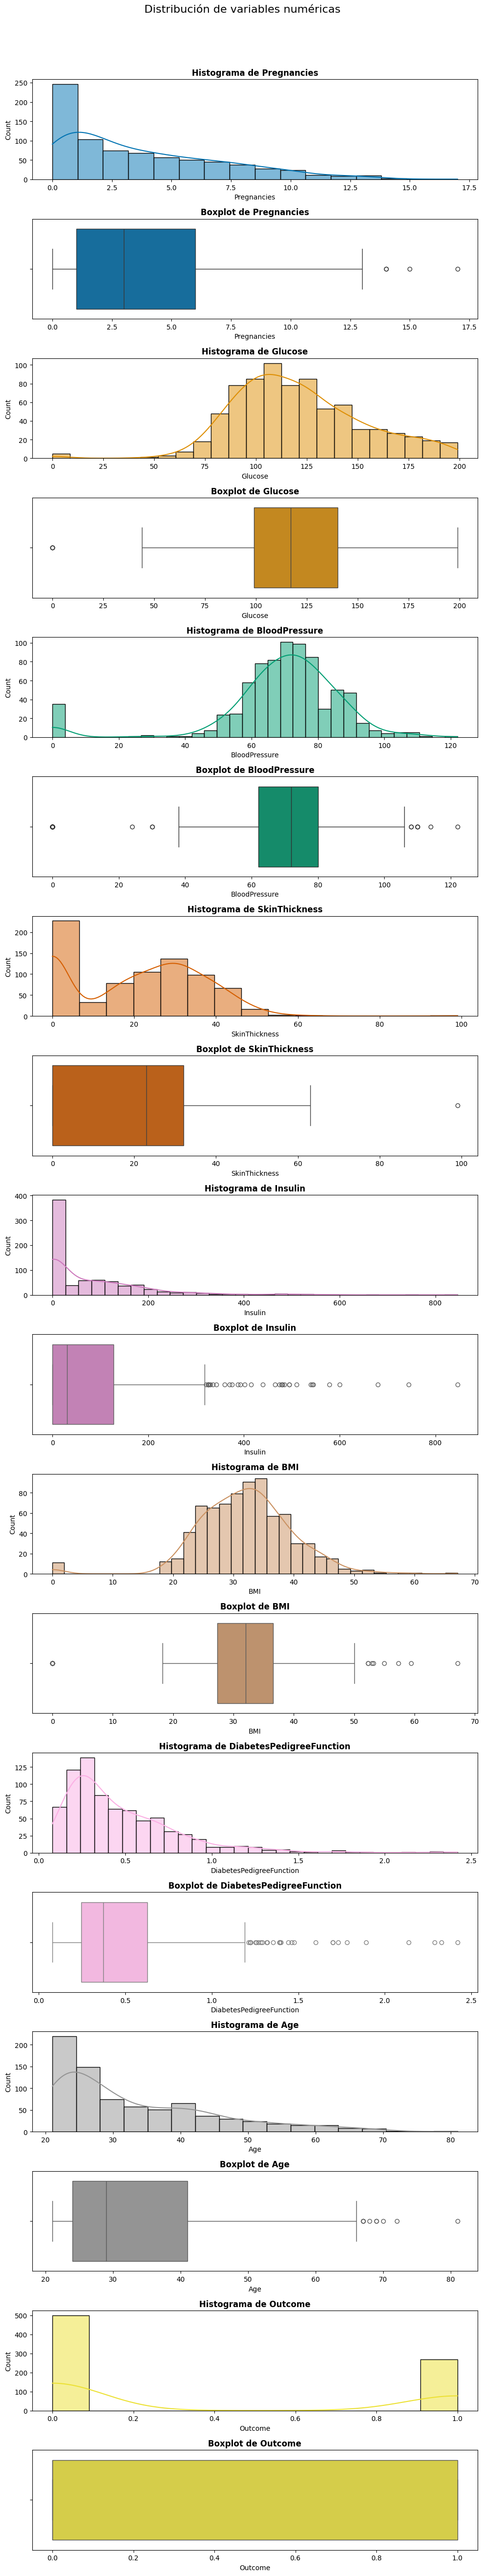

In [122]:
# Figura: 2 filas por variable, 1 columna
fig, axes = plt.subplots(
    nrows=2 * num_vars,
    ncols=1,
    figsize=(10, 3 * 2 * num_vars)  # alto proporcional al nº de variables
)

plt.suptitle('Distribución de variables numéricas', fontsize=16, y=0.995)

# Aseguramos que axes es siempre un array 1D
axes = np.array(axes).flatten()

# Paleta: un color por variable
palette = sns.color_palette("colorblind", num_vars)

for i, col in enumerate(num_cols):
    color = palette[i % len(palette)]
    
    # índice de las filas para esta variable
    idx_hist = i * 2        # fila del histograma
    idx_box  = i * 2 + 1    # fila del boxplot

    # Histograma (arriba)
    sns.histplot(
        data=df_eda,
        x=col,
        kde=True,
        ax=axes[idx_hist],
        color=color
    )
    axes[idx_hist].set_title(f'Histograma de {col}', fontweight='bold')

    # Boxplot (abajo)
    sns.boxplot(
        data=df_eda,
        x=col,
        ax=axes[idx_box],
        color=color
    )
    axes[idx_box].set_title(f'Boxplot de {col}', fontweight='bold')
    axes[idx_box].set(xlabel=col)

plt.tight_layout(rect=[0, 0.02, 1, 0.98])
plt.show()


### Conclusiones del análisis univariante numérico

- `Glucose` parece tener una distribución claramente diferente entre personas con y sin diabetes (lo comprobaremos en el análisis bivariante).
- Algunas variables (como `Insulin` o `SkinThickness`) muestran mucha asimetría y posibles outliers.
- El rango de `BMI` y `Age` es coherente con una población adulta.

## 3.2 Analisis de variables categoricas

#### Dado que el dataset solo cuenta con variables numericas, un analisis de variables categoricas no aplica en este caso

# 4. Análisis de variables multivariante

### Tras analizar las características una a una, es momento de analizarlas en relación con la predictora y con ellas mismas, para sacar conclusiones más claras acerca de sus relaciones y poder tomar decisiones sobre su procesamiento.

### Así, si quisiéramos eliminar una variable debido a una alta cantidad de valores nulos o ciertos outliers, es necesario antes aplicar este proceso para asegurar que la eliminación de ciertos valores no son críticos

## 4.1 Análisis numérico-numérico:

#### Cuando las dos variables que se comparan tienen datos numéricos, se dice que el análisis es numérico-numérico. Para comparar dos columnas numéricas se utilizan diagramas de dispersión y análisis de correlaciones

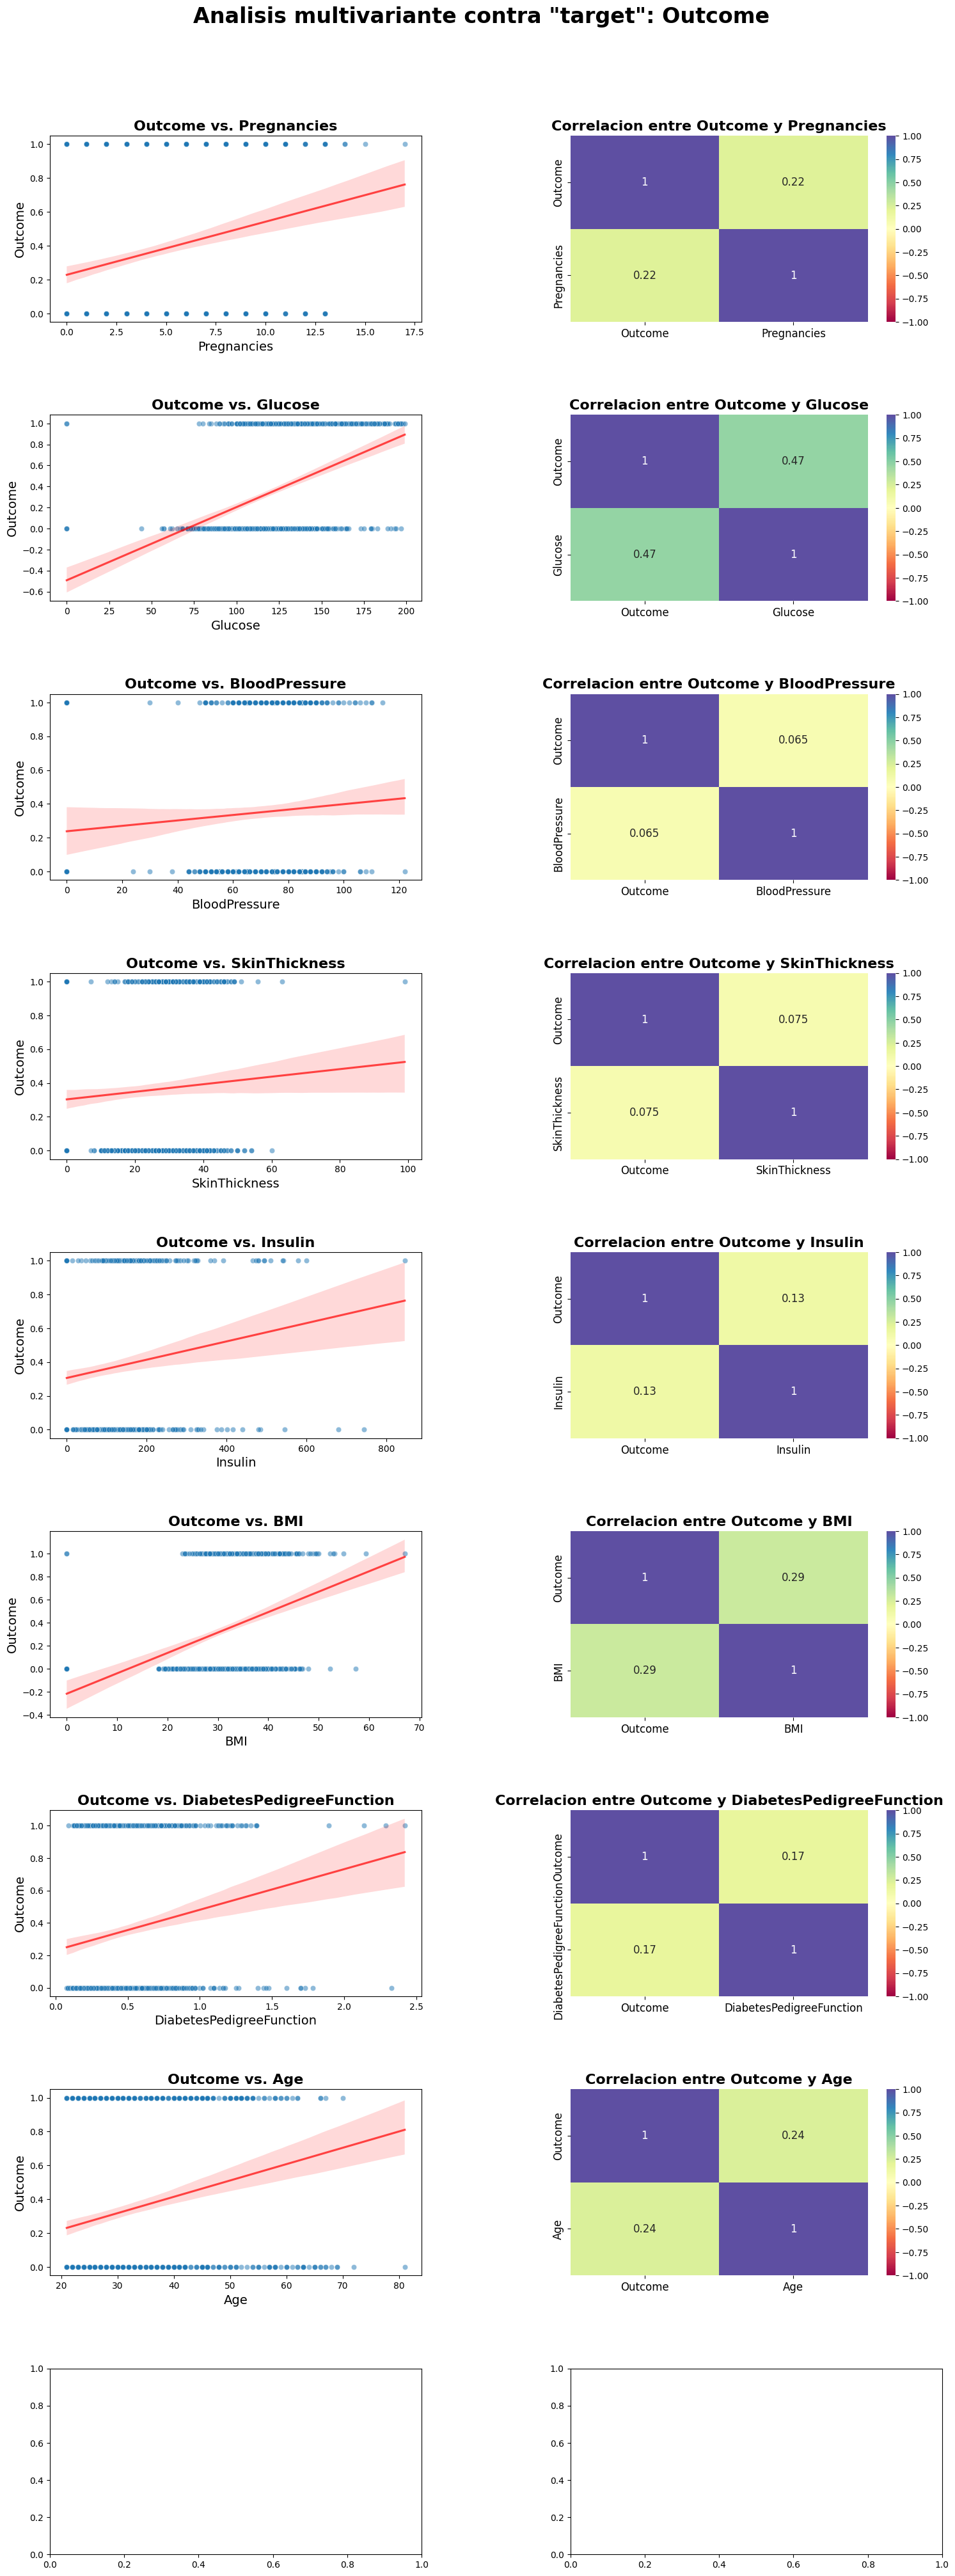

In [123]:
target = 'Outcome'
num_cols = df_eda.drop(columns=[target]).select_dtypes(include=["int64", "float64"]).columns.tolist()

fig, axes = plt.subplots(num_vars, 2, figsize=(18, num_vars * 5))
fig.suptitle(f'Analisis multivariante contra "target": {target}', fontsize=24, fontweight='bold', y=0.995)

for i, col in enumerate(num_cols):
    # Scatterplot con regresion lineal
    sns.scatterplot(ax=axes[i, 0], data=df_eda, x=col, y=target, alpha=0.5)
    sns.regplot(ax=axes[i, 0], data=df_eda, x=col, y=target, scatter=False, color='red', line_kws={"alpha":0.7})
    axes[i, 0].set_title(f'{target} vs. {col}', fontsize=16, fontweight='bold')
    axes[i, 0].set_xlabel(col, fontsize=14)
    axes[i, 0].set_ylabel(target, fontsize=14)
    
    # Matriz de correlacion entre la target y la variable numerica
    corr_data = df_eda[[target, col]].corr()
    sns.heatmap(ax=axes[i, 1], data=corr_data, annot=True, cmap='Spectral', cbar=True, vmin=-1, vmax=1, annot_kws={"size": 12})
    axes[i, 1].set_title(f'Correlacion entre {target} y {col}', fontsize=16, fontweight='bold')
    axes[i, 1].tick_params(axis='both', which='major', labelsize=12)

plt.subplots_adjust(top=0.95, hspace=0.5, wspace=0.4)
plt.show()


### Conclusiones del análisis multivariante (variables numéricas vs `Outcome`)

En este apartado analizamos la relación entre la variable objetivo `Outcome`
(0 = no diabetes, 1 = diabetes) y cada una de las variables numéricas, usando:

- Gráficos de dispersión con recta de regresión lineal.
- Matrices de correlación de Pearson `corr(Outcome, variable)`.

A nivel general:

- Una **pendiente positiva** en la recta roja indica que, a medida que aumenta
  la variable, **aumenta la probabilidad de `Outcome = 1`** (diabetes).
- Valores de correlación cercanos a 0 indican **poca relación lineal directa**,
  mientras que valores más altos (en valor absoluto) indican una relación más fuerte.

#### Pregnancies

- La pendiente de la recta es **ligeramente positiva**: a más embarazos,
  aumenta modestamente la probabilidad de diabetes.
- La correlación con `Outcome` es **baja pero positiva**.
- Intuición: el número de embarazos puede estar relacionado con cambios
  metabólicos a lo largo de la vida, pero no es una variable determinante por sí sola.

#### Glucose

- Es la variable con una relación más clara: la pendiente de la recta es
  **claramente positiva**.
- La correlación con `Outcome` es **moderada/alta y positiva**.
- Conclusión: **niveles más altos de glucosa** se asocian fuertemente con
  mayor probabilidad de diabetes. Es una de las variables clave que el modelo
  probablemente utilizará para separar clases.

#### BloodPressure

- La nube de puntos está bastante dispersa y la pendiente de la recta es
  cercana a **horizontal**.
- La correlación con `Outcome` es **muy baja**, prácticamente nula.
- Conclusión: la **presión arterial diastólica**, tal y como está medida en
  este dataset, **no parece ser un buen predictor lineal de diabetes**.
  Aun así, un árbol de decisión podría capturar algún efecto en ciertos
  rangos concretos.

#### SkinThickness

- Existe bastante dispersión y muchos valores alrededor de un rango limitado.
- La correlación con `Outcome` es **baja**, la recta tiene ligera pendiente
  positiva pero no muy marcada.
- Además, esta variable suele tener **muchos ceros o valores atípicos**, lo
  que puede estar reflejando problemas de medición o datos ausentes codificados
  como 0.
- Conclusión: por sí sola no muestra una relación lineal fuerte con diabetes.

#### Insulin

- La nube de puntos suele mostrar muchos valores en 0 y algunos valores muy
  altos, generando una distribución muy sesgada.
- La correlación con `Outcome` suele ser **positiva pero débil/moderada**.
- Debido a la cantidad de ceros, es probable que la calidad del dato no sea
  óptima y que el modelo tenga dificultades para extraer una señal clara
  sin un tratamiento previo (por ejemplo, imputando o transformando la variable).

#### BMI (Índice de masa corporal)

- La pendiente de la recta es **positiva**: a mayor BMI, mayor probabilidad
  de `Outcome = 1`.
- La correlación con `Outcome` es **moderada y positiva**.
- Conclusión: el **sobrepeso/obesidad** (BMI alto) se asocia con mayor
  riesgo de diabetes, y esta variable es probablemente importante para el modelo.

#### DiabetesPedigreeFunction

- La recta tiene una pendiente positiva, aunque no tan pronunciada como en
  el caso de `Glucose` o `BMI`.
- La correlación con la variable objetivo es **positiva, de magnitud baja
  a moderada**.
- Conclusión: el componente **genético / familiar** de riesgo de diabetes
  está presente, pero no es el factor dominante.

#### Age

- La pendiente es **positiva**: a mayor edad, aumenta la probabilidad
  de tener diabetes.
- La correlación con `Outcome` es **moderada**.
- Conclusión: la edad influye en el riesgo de diabetes, como era de esperar,
  aunque su efecto no es tan fuerte como el de `Glucose` o `BMI`.

---

### Implicaciones para el modelo de Árbol de Decisión

- Las variables que muestran una relación más clara con `Outcome` a nivel
  lineal son principalmente:
  - **Glucose**
  - **BMI**
  - **Age**
  - (en menor medida) **DiabetesPedigreeFunction** y **Pregnancies**.

- Variables como **BloodPressure**, **SkinThickness** e **Insulin** muestran
  correlaciones lineales débiles, pero un Árbol de Decisión podría seguir
  encontrando reglas útiles en ciertos rangos (por ejemplo, valores muy extremos).

- La matriz de correlaciones nos da una primera idea de qué variables serán
  más útiles en el modelo, pero:
  - No captura relaciones **no lineales**.
  - No tiene en cuenta **interacciones** entre variables (por ejemplo,
    combinaciones de edad y glucosa).

Por eso, en los siguientes pasos (entrenamiento del árbol y análisis de
`feature_importances_`) comprobaremos si estas intuiciones se confirman
y qué variables acaban siendo más importantes para la clasificación.

## 4.2 Matriz de Correlaciones

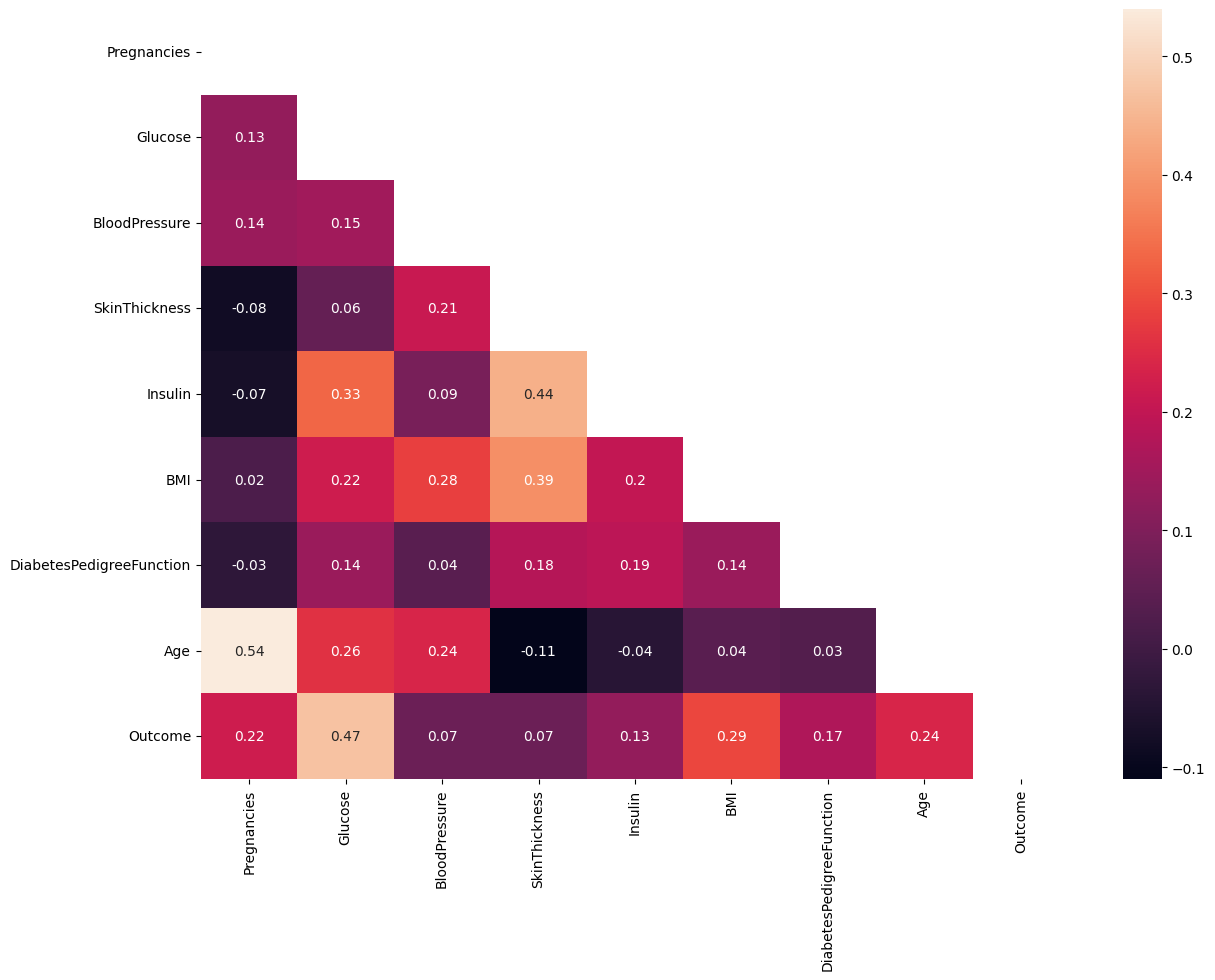

In [124]:
plt.figure(figsize=(14,10))
sns.heatmap(df_eda.corr().round(2), annot=True, mask=np.triu(df_eda.corr()))
plt.show()

# 5. Ingeniería de características

### La ingeniería de características (feature engineering) es un proceso que implica la creación de nuevas características (o variables) a partir de las existentes para mejorar el rendimiento del modelo. Esto puede implicar una variedad de técnicas como la normalización, la transformación de los datos, etcétera. El objetivo es mejorar la precisión del modelo y/o reducir la complejidad del mismo, facilitando así su interpretación.

### En los pasos previos hemos empezado a trabajar con los datos eliminando duplicados, contabilizando los valores nulos e, incluso, para calcular correlaciones. Si bien esto podríamos haberlo hecho en este paso, ya que forma parte de la ingeniería de características, normalmente suele hacerse antes de analizar las variables, separando este proceso en uno previo y este que vamos a ver a continuación.

## 5.1 Análisis de outliers

#### Un valor atípico (outlier) es un punto de datos que se desvía significativamente de los demás. Es un valor que es notablemente diferente de lo que sería de esperar dada la tendencia general de los datos. Estos outliers pueden ser causados por errores en la recolección de datos, variaciones naturales en los datos, o pueden ser indicativos de algo significativo, como una anomalía o evento extraordinario.

#### El análisis descriptivo es una poderosa herramienta para caracterizar el conjunto de datos: la media, desviación y los cuartiles nos brindan una poderosa información sobre cada variable. La función describe() de un DataFrame nos ayuda a calcular en unos tiempos muy reducidos todos estos valores.

In [125]:
df_stats = df.describe()
df_stats

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000,768.000,768.000,768.000,768.000,768.000,768.000,768.000,768.000
mean,3.845,120.895,69.105,20.536,79.799,31.993,0.472,33.241,0.349
std,3.370,31.973,19.356,15.952,115.244,7.884,0.331,11.760,0.477
min,0.000,0.000,0.000,0.000,0.000,0.000,0.078,21.000,0.000
25%,1.000,99.000,62.000,0.000,0.000,27.300,0.244,24.000,0.000
50%,3.000,117.000,72.000,23.000,30.500,32.000,0.372,29.000,0.000
75%,6.000,140.250,80.000,32.000,127.250,36.600,0.626,41.000,1.000
max,17.000,199.000,122.000,99.000,846.000,67.100,2.420,81.000,1.000


In [126]:
outlier_cols = list(num_cols)

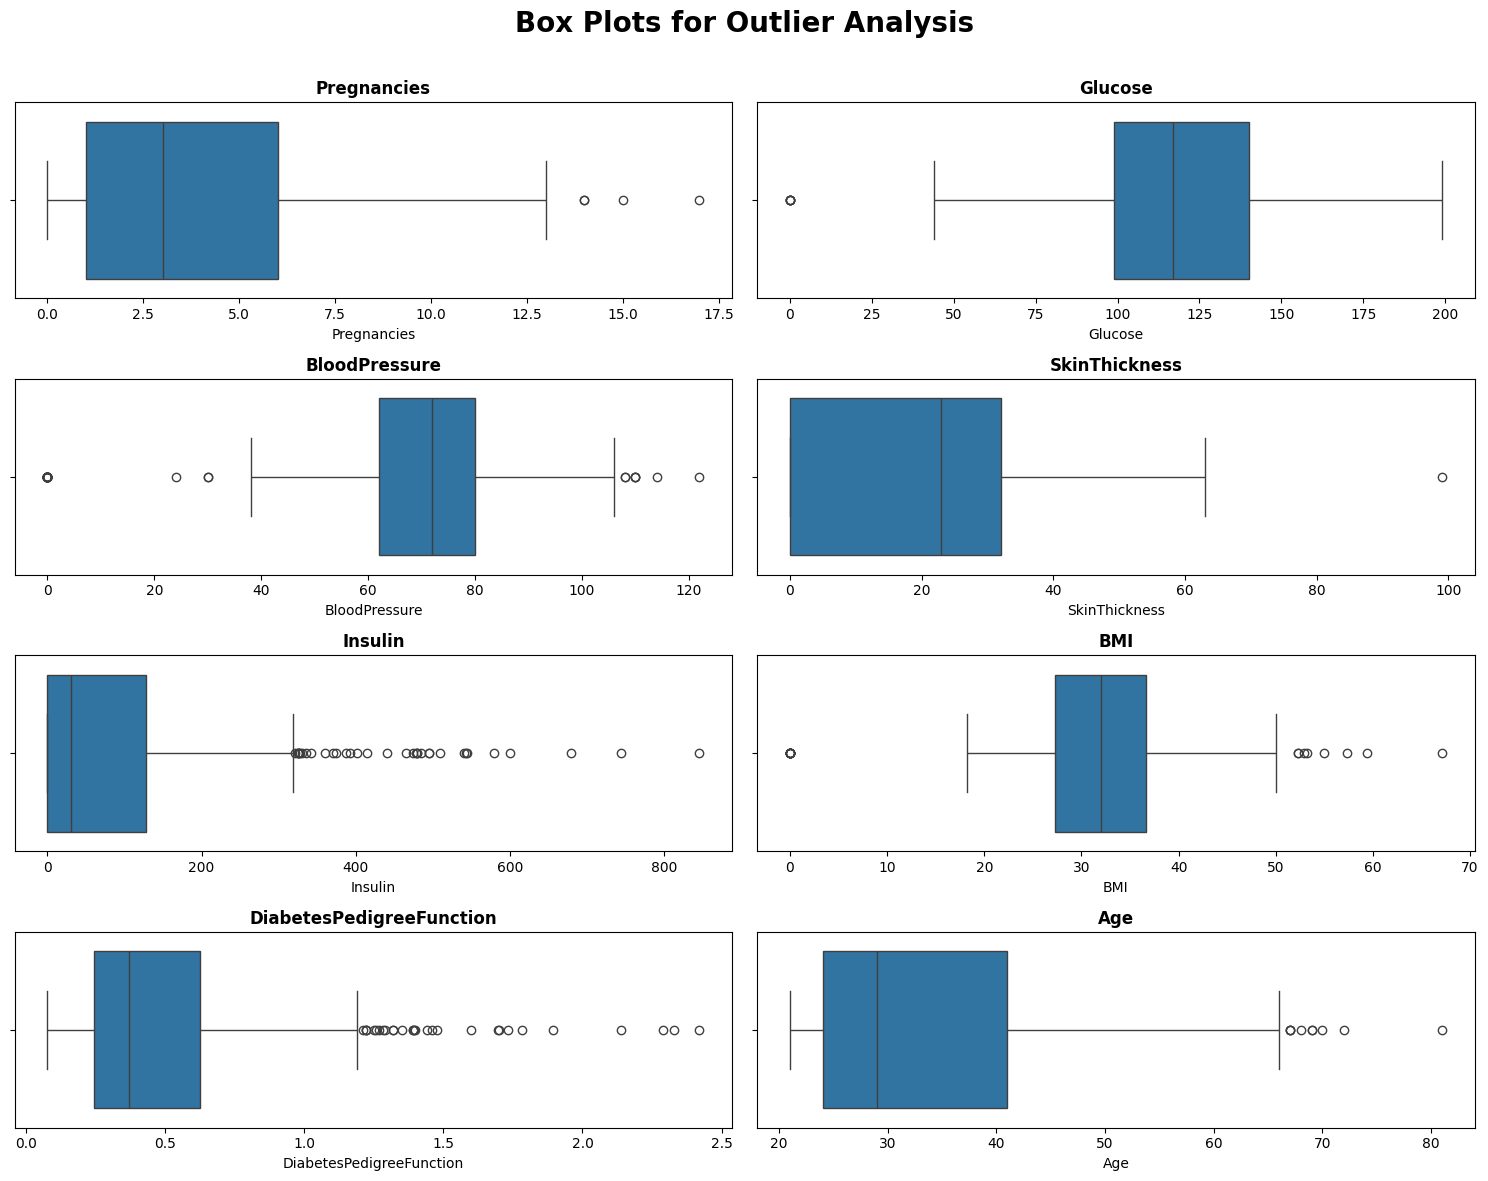

In [127]:
num_vars = len(outlier_cols)
num_rows = math.ceil(num_vars / 2)  

fig, axes = plt.subplots(num_rows, 2, figsize=(15, num_rows * 3))
fig.suptitle('Box Plots for Outlier Analysis', fontsize=20, fontweight='bold')


for i, var in enumerate(outlier_cols):
    row, col = divmod(i, 2)  
    sns.boxplot(ax=axes[row, col], data=df, x=var)
    axes[row, col].set_title(var, fontweight='bold')


plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

In [128]:
def def_outliers(df_stats, variable, json_file):

    individual_stats = df_stats[variable] # guardard stats para el IQR

    iqr = individual_stats["75%"] - individual_stats["25%"]
    upper_limit = individual_stats["75%"] + (2 * iqr) 
    lower_limit = individual_stats["25%"] - (2 * iqr)

    if (lower_limit < 0): lower_limit = 0

    print(f"\nEl limite superior de la variable {variable} es {round(upper_limit, 3)}, el limite inferior {round(lower_limit, 3)} y el IQR es {round(iqr, 3)}")
    print('                      ==========================================                  ')
    with open(json_file, "w") as f:
        json.dump({
            "upper_limit": upper_limit,
            "lower_limit": lower_limit
        }, f)

In [129]:
for variable in num_cols:
        def_outliers(df_stats, variable, f"../data/interim/outliers_{variable}.json")


El limite superior de la variable Pregnancies es 16.0, el limite inferior 0 y el IQR es 5.0

El limite superior de la variable Glucose es 222.75, el limite inferior 16.5 y el IQR es 41.25

El limite superior de la variable BloodPressure es 116.0, el limite inferior 26.0 y el IQR es 18.0

El limite superior de la variable SkinThickness es 96.0, el limite inferior 0 y el IQR es 32.0

El limite superior de la variable Insulin es 381.75, el limite inferior 0 y el IQR es 127.25

El limite superior de la variable BMI es 55.2, el limite inferior 8.7 y el IQR es 9.3

El limite superior de la variable DiabetesPedigreeFunction es 1.391, el limite inferior 0 y el IQR es 0.382

El limite superior de la variable Age es 75.0, el limite inferior 0 y el IQR es 17.0


In [130]:
# Guardamos todos los datasets:

total_data_CON_outliers = df.copy()
total_data_SIN_outliers = df.copy()

In [131]:
# Abrir JSON Outliers

def open_outliers(total_data_SIN_outliers, variable, json_path):

    with open(json_path, "r") as f:
        outliers = json.load(f)

    upper_limit_ = outliers["upper_limit"]

    lower_limit_ = outliers["lower_limit"]

    total_data_SIN_outliers[variable] = total_data_SIN_outliers[variable].apply(
        lambda x: upper_limit_ if (x > upper_limit_) else (lower_limit_ if (x < lower_limit_) else x)
                )


In [132]:
for variable in num_cols:
    open_outliers(total_data_SIN_outliers, variable, f"../data/interim/outliers_{variable}.json")

### 5.2 Análisis de valores faltantes

In [133]:
print(total_data_CON_outliers.isnull().sum().sort_values(ascending=False))
total_data_SIN_outliers.isnull().sum().sort_values(ascending=False)

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

#### No hay valores faltantes a los que hacerle tratamiento

## 5.3 Escalado de valores

#### El escalado de valores (feature scaling) es un paso crucial en el preprocesamiento de datos para muchos algoritmos de Machine Learning. Es una técnica que cambia el rango de los valores de los datos para que puedan ser comparables entre sí. El escalado normalmente implica la normalización, que es el proceso de cambiar los valores para que tengan una media de 0 y una desviación estándar de 1. Otra técnica común es el escalado mínimo-máximo, que transforma los datos para que todos los valores estén entre 0 y 1.

#### Antes de escalar los valores, debemos asegurarnos de que todas nuestras variables predictoras sean numéricas. Una vez preparadas, podemos aplicar técnicas como la normalización o el escalado Min-Max directamente sobre el dataset completo. Más adelante, cuando pasemos a la fase de modelado, será el momento de dividir los datos en entrenamiento y prueb

In [134]:
predictoras = [col for col in num_cols if col != target]

# total_data_SIN_outliers
# total_data_CON_outliers
X_CON = total_data_CON_outliers.drop(target, axis = 1)[predictoras]
X_SIN = total_data_SIN_outliers.drop(target, axis = 1)[predictoras]
y = total_data_CON_outliers[target]

X_train_CON_outliers, X_test_CON_outliers, y_train, y_test = train_test_split(X_CON, y, test_size = 0.2, random_state = 10)
X_train_SIN_outliers, X_test_SIN_outliers = train_test_split(X_SIN, test_size = 0.2, random_state = 10)

In [135]:
# Normalización

norm_CON_outliers = StandardScaler()

norm_CON_outliers.fit(X_train_CON_outliers)

X_train_CON_outliers_norm = norm_CON_outliers.transform(X_train_CON_outliers)
X_train_CON_outliers_norm = pd.DataFrame(X_train_CON_outliers_norm, index = X_train_CON_outliers.index, columns = predictoras)

X_test_CON_outliers_norm = norm_CON_outliers.transform(X_test_CON_outliers)
X_test_CON_outliers_norm = pd.DataFrame(X_test_CON_outliers_norm, index = X_test_CON_outliers.index, columns = predictoras)

# SIN OUTLIERS

norm_SIN_outliers = StandardScaler()
norm_SIN_outliers.fit(X_train_SIN_outliers)

X_train_SIN_outliers_norm = norm_SIN_outliers.transform(X_train_SIN_outliers)
X_train_SIN_outliers_norm = pd.DataFrame(X_train_SIN_outliers_norm, index = X_train_SIN_outliers.index, columns = predictoras)

X_test_SIN_outliers_norm = norm_SIN_outliers.transform(X_test_SIN_outliers)
X_test_SIN_outliers_norm = pd.DataFrame(X_test_SIN_outliers_norm, index = X_test_SIN_outliers.index, columns = predictoras)


# ESCALADO MIN-MAX (MINMAXIMIZACIÓN)

scaler_CON_outliers = MinMaxScaler()
scaler_CON_outliers.fit(X_train_CON_outliers)

X_train_CON_outliers_scal = scaler_CON_outliers.transform(X_train_CON_outliers)
X_train_CON_outliers_scal = pd.DataFrame(X_train_CON_outliers_scal, index = X_train_CON_outliers.index, columns = predictoras)

X_test_CON_outliers_scal = scaler_CON_outliers.transform(X_test_CON_outliers)
X_test_CON_outliers_scal = pd.DataFrame(X_test_CON_outliers_scal, index = X_test_CON_outliers.index, columns = predictoras)

# SIN OUTLIERS

scaler_SIN_outliers = MinMaxScaler()
scaler_SIN_outliers.fit(X_train_SIN_outliers)

X_train_SIN_outliers_scal = scaler_SIN_outliers.transform(X_train_SIN_outliers)
X_train_SIN_outliers_scal = pd.DataFrame(X_train_SIN_outliers_scal, index = X_train_SIN_outliers.index, columns = predictoras)

X_test_SIN_outliers_scal = scaler_SIN_outliers.transform(X_test_SIN_outliers)
X_test_SIN_outliers_scal = pd.DataFrame(X_test_SIN_outliers_scal, index = X_test_SIN_outliers.index, columns = predictoras)


# Guardado de los datasets resultantes

X_train_CON_outliers.to_csv("../data/processed/X_train_CON_outliers.csv", index = False)
X_train_CON_outliers_norm.to_csv("../data/processed/X_train_CON_outliers_norm.csv", index = False)
X_train_CON_outliers_scal.to_csv("../data/processed/X_train_CON_outliers_scal.csv", index = False)
X_train_SIN_outliers.to_csv("../data/processed/X_train_SIN_outliers.csv", index = False)
X_train_SIN_outliers_norm.to_csv("../data/processed/X_train_SIN_outliers_norm.csv", index = False)
X_train_SIN_outliers_scal.to_csv("../data/processed/X_train_SIN_outliers_scal.csv", index = False)

X_test_CON_outliers.to_csv("../data/processed/X_test_CON_outliers.csv", index = False)
X_test_CON_outliers_norm.to_csv("../data/processed/X_test_CON_outliers_norm.csv", index = False)
X_test_CON_outliers_scal.to_csv("../data/processed/X_test_CON_outliers_scal.csv", index = False)
X_test_SIN_outliers.to_csv("../data/processed/X_test_SIN_outliers.csv", index = False)
X_test_SIN_outliers_norm.to_csv("../data/processed/X_test_SIN_outliers_norm.csv", index = False)
X_test_SIN_outliers_scal.to_csv("../data/processed/X_test_SIN_outliers_scal.csv", index = False)

y_train.to_csv("../data/processed/y_train.csv", index = False)
y_test.to_csv("../data/processed/y_test.csv", index = False)

# SCALERS

with open("../models/norm_CON_outliers.pkl", "wb") as file:
  pickle.dump(norm_CON_outliers, file)
with open("../models/norm_SIN_outliers.pkl", "wb") as file:
  pickle.dump(norm_SIN_outliers, file)
with open("../models/scaler_CON_outliers.pkl", "wb") as file:
  pickle.dump(scaler_CON_outliers, file)
with open("../models/scaler_SIN_outliers.pkl", "wb") as file:
  pickle.dump(scaler_SIN_outliers, file)

In [136]:
y_test

568    0
620    0
456    0
197    1
714    0
      ..
264    1
706    1
194    0
179    1
514    0
Name: Outcome, Length: 154, dtype: int64

# Machine Learning

# 6. Selección de características

#### La selección de características (feature selection) es un proceso que implica seleccionar las características (variables) más relevantes de nuestro conjunto de datos para usarlas en la construcción de un modelo de Machine Learning, desechando el resto.

#### Existen varias razones para incluirlo en nuestro análisis exploratorio:

1. Simplificar el modelo para que sea más fácil de entender e interpretar.
2. Reducir el tiempo de entrenamiento del modelo.
3. Evitar el sobre ajuste al reducir la dimensionalidad del modelo y minimizar el ruido y las correlaciones innecesarias.
4. Mejorar el rendimiento del modelo al eliminar las características irrelevantes.

In [137]:
X_train = X_train_CON_outliers.copy()
X_test = X_test_CON_outliers.copy()

selection_model = SelectKBest(f_classif, k = 5)
selection_model.fit(X_train, y_train)

ix = selection_model.get_support()
X_train_sel = pd.DataFrame(selection_model.transform(X_train), columns = X_train.columns.values[ix])
X_test_sel = pd.DataFrame(selection_model.transform(X_test), columns = X_test.columns.values[ix])

X_train_sel.head()

,Pregnancies,Glucose,BMI,DiabetesPedigreeFunction,Age
0,0.000,162.000,53.200,0.759,25.000
1,2.000,87.000,28.900,0.773,25.000
2,0.000,137.000,24.800,0.143,21.000
3,10.000,115.000,35.300,0.134,29.000
4,0.000,104.000,33.600,0.510,22.000


### 6.1 Entrenamiento del modelo

In [138]:
X_train_CON_outliers = pd.read_csv("../data/processed/X_train_CON_outliers.csv")

X_train_SIN_outliers = pd.read_csv("../data/processed/X_train_SIN_outliers.csv")

y_train = pd.read_csv("../data/processed/y_train.csv")

datasets = [X_train_CON_outliers, X_train_SIN_outliers]

models = []
metrics = []

for dataset in datasets:

    model = DecisionTreeClassifier(max_depth=3, random_state=10)
    model.fit(dataset, y_train)
    y_pred = model.predict(dataset)
    metric = accuracy_score(y_train, y_pred)
    metrics.append(metric)
    models.append(model)


best_metric = max(metrics)
best_index = metrics.index(best_metric)

print(f"El mejor dataset para entrenar el modelo es: \n{datasets[best_index]}")
print(f"La mejor métrica es: \n{best_metric}")

model = DecisionTreeClassifier(max_depth=3, random_state=10)
model.fit(datasets[best_index], y_train)

El mejor dataset para entrenar el modelo es: 
     Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin    BMI  \
0              0      162             76             56      100 53.200   
1              2       87              0             23        0 28.900   
2              0      137             68             14      148 24.800   
3             10      115              0              0        0 35.300   
4              0      104             64             37       64 33.600   
..           ...      ...            ...            ...      ...    ...   
609            1      133            102             28      140 32.800   
610            4      129             60             12      231 27.500   
611            3      116             74             15      105 26.300   
612            1       88             30             42       99 55.000   
613            5       96             74             18       67 33.600   

     DiabetesPedigreeFunction  Age  
0               

,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.",'gini'
,"splitter splitter: {""best"", ""random""}, default=""best""The strategy used to choose the split at each node. Supportedstrategies are ""best"" to choose the best split and ""random"" to choosethe best random split.",'best'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",3
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: int, float or {""sqrt"", ""log2""}, default=NoneThe number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... note:: The search for a split does not stop until at least one valid partition of the node samples is found, even if it requires to effectively inspect more than ``max_features`` features.",None
,"random_state random_state: int, RandomState instance or None, default=NoneControls the randomness of the estimator. The features are alwaysrandomly permuted at each split, even if ``splitter`` is set to``""best""``. When ``max_features < n_features``, the algorithm willselect ``max_features`` at random at each split before finding the bestsplit among them. But the best found split may vary across differentruns, even if ``max_features=n_features``. That is the case, if theimprovement of the criterion is identical for several splits and onesplit has to be selected at random. To obtain a deterministic behaviourduring fitting, ``random_state`` has to be fixed to an integer.See :term:`Glossary ` for details.",10
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow a tree with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current no

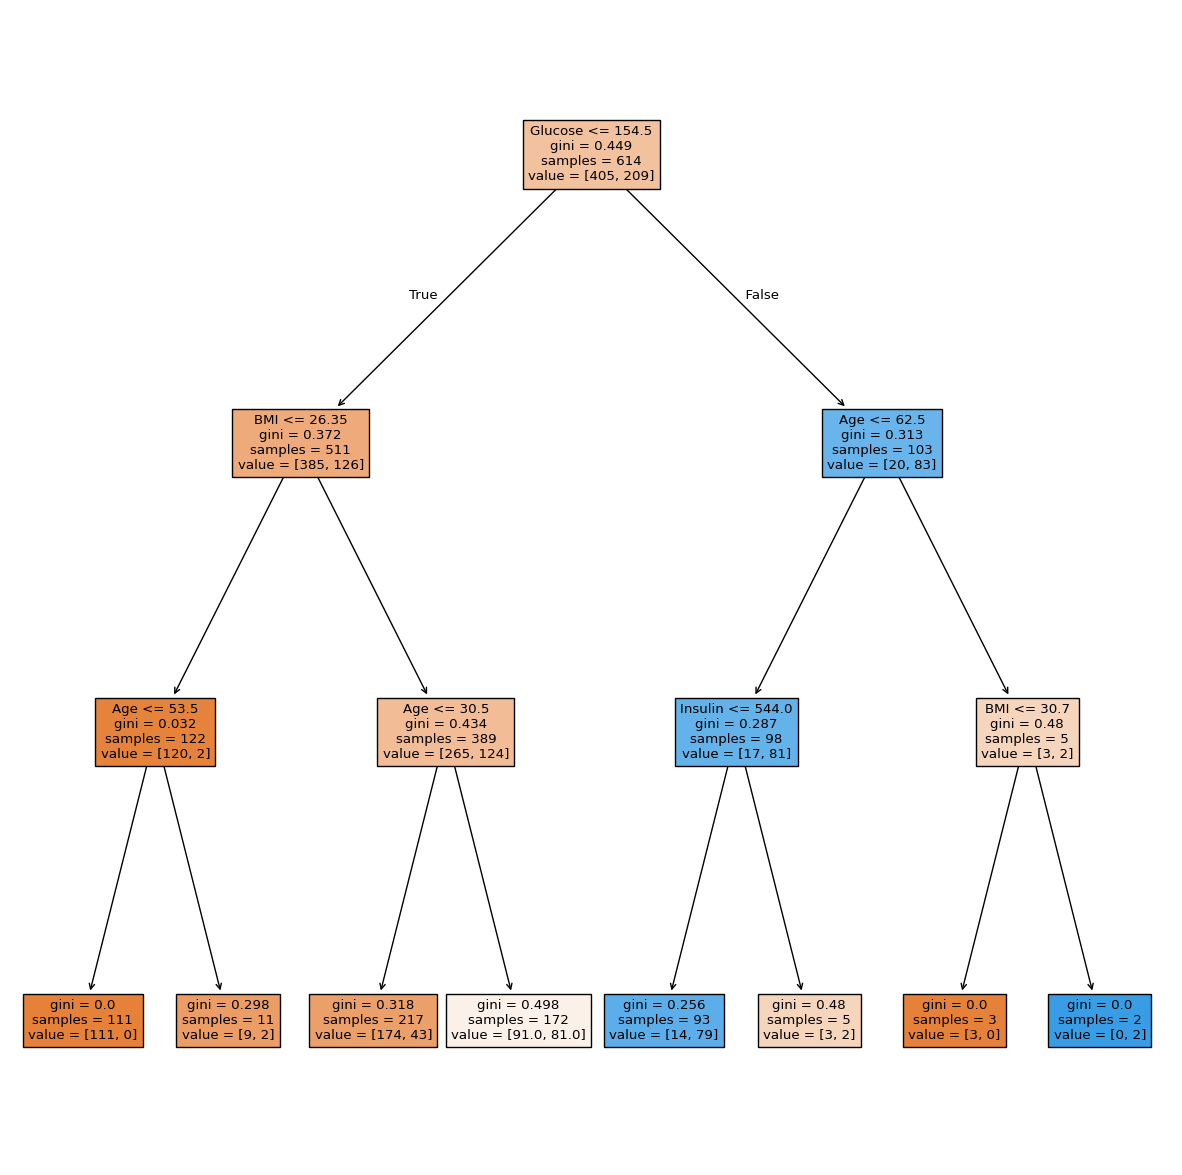

In [139]:
fig = plt.figure(figsize=(15,15))

tree.plot_tree(model, feature_names = list(datasets[best_index].columns), filled = True)

plt.show()

## 7. Optimizacion de hiperparámetros

In [140]:
params= {
    "criterion": ["gini", "entropy", "log_loss"],
    "max_depth": [3, 5, 8],
    "min_samples_split": [2, 4, 6], 
    "min_samples_leaf": [1, 3, 5], 
    "max_features": [None, "sqrt", "log2"], 
    "min_impurity_decrease": [0.0, 0.1, 0.5], 
    "class_weight": [None, "balanced"],
    "ccp_alpha": [0.0, 0.1, 0.01]
}

#### 6.1.1 Grid Search

In [ ]:
grid = GridSearchCV(DecisionTreeClassifier(random_state=10), params, scoring="accuracy", cv=5, n_jobs = -1)
grid.fit(datasets[best_index], y_train)

best_model = grid.best_estimator_
print("El mejor estimador es: ", best_model)
print("La mejor puntuación es: ", grid.best_score_)

#### 6.1.2 Random Search

In [ ]:
grid = RandomizedSearchCV(DecisionTreeClassifier(random_state=10), params, scoring="accuracy", n_iter = 30, cv=5, n_jobs = -1)
grid.fit(datasets[best_index], y_train)
best_model = grid.best_estimator_

print("El mejor estimador es: ", best_model)
print("La mejor puntuación es: ", grid.best_score_)

El mejor estimador es:  DecisionTreeClassifier(max_depth=8, max_features='log2', min_samples_leaf=5,
                       min_samples_split=6, random_state=10)
La mejor puntuación es:  0.734546181527389


### 6.3 Entrenamiento del modelo de ML

In [ ]:
X_test_CON_outliers = pd.read_csv("../data/processed/X_test_CON_outliers.csv")
X_test_SIN_outliers = pd.read_csv("../data/processed/X_test_SIN_outliers.csv")


y_test = pd.read_csv("../data/processed/y_test.csv")

datasets_test = [X_test_CON_outliers,
    X_test_SIN_outliers
    ]


model_f = DecisionTreeClassifier(ccp_alpha=0.01, criterion='entropy', max_depth=8,
                       random_state=10)
model_f.fit(datasets[best_index], y_train)

y_pred = model_f.predict(datasets[best_index])
metric_train = accuracy_score(y_train, y_pred)


y_pred = model_f.predict(datasets_test[best_index])
metric_test = accuracy_score(y_test, y_pred)


print(f"La métrica optimizada de nuestros datasets son: x_train: {metric_train}, x_test: {metric_test}")

La mejor métrica de nuestros datasets x_train son: 0.7947882736156352 y los x_test son: 0.7662337662337663


[Text(0.4791666666666667, 0.9375, 'x[1] <= 154.5\nentropy = 0.925\nsamples = 614\nvalue = [405, 209]'),
 Text(0.3958333333333333, 0.8125, 'x[5] <= 26.35\nentropy = 0.806\nsamples = 511\nvalue = [385, 126]'),
 Text(0.4375, 0.875, 'True  '),
 Text(0.16666666666666666, 0.6875, 'x[7] <= 53.5\nentropy = 0.121\nsamples = 122\nvalue = [120, 2]'),
 Text(0.08333333333333333, 0.5625, 'entropy = 0.0\nsamples = 111\nvalue = [111, 0]'),
 Text(0.25, 0.5625, 'entropy = 0.684\nsamples = 11\nvalue = [9, 2]'),
 Text(0.625, 0.6875, 'x[7] <= 30.5\nentropy = 0.903\nsamples = 389\nvalue = [265, 124]'),
 Text(0.4166666666666667, 0.5625, 'x[1] <= 118.5\nentropy = 0.718\nsamples = 217\nvalue = [174, 43]'),
 Text(0.25, 0.4375, 'x[5] <= 45.4\nentropy = 0.528\nsamples = 134\nvalue = [118, 16]'),
 Text(0.16666666666666666, 0.3125, 'x[6] <= 0.501\nentropy = 0.488\nsamples = 132\nvalue = [118, 14]'),
 Text(0.08333333333333333, 0.1875, 'entropy = 0.302\nsamples = 93\nvalue = [88, 5]'),
 Text(0.25, 0.1875, 'x[5] <= 32

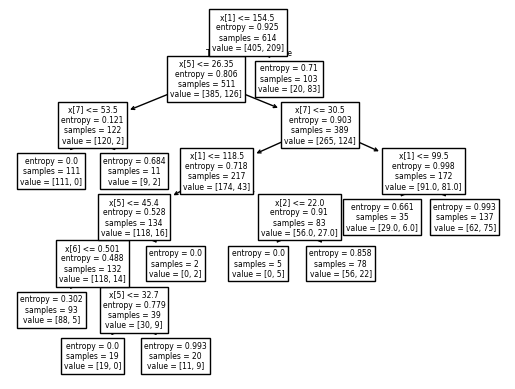

In [ ]:
plot_tree(model_f)